In [142]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [143]:
import pandas as pd

In [144]:
train = pd.read_csv('/content/drive/MyDrive/AISpark/scaled_data/train_scaled.csv')

In [145]:
import numpy as np
from sklearn.model_selection import train_test_split

In [146]:
X_train, X_test=train_test_split(train, test_size = 0.2, random_state=5, shuffle=False)

In [147]:
len_X = len(X_train)
len_train = int(0.8 * len_X)

In [148]:
#y_test = np.ones(len(X_test))

In [149]:
test = pd.read_csv('/content/drive/MyDrive/AISpark/scaled_data/test_scaled.csv')

In [150]:
test

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,0.382550,0.299934,0.0,0.341372,0.256260,0.304576,0.255637,0
1,0.483221,0.429993,0.0,0.443730,0.387312,0.435109,0.355373,0
2,-0.147651,-0.399469,0.0,-0.211147,-0.447412,-0.398350,-0.313396,0
3,0.174497,0.025879,0.0,0.124866,-0.019199,0.029257,0.047798,0
4,0.080537,-0.098208,0.0,0.026795,-0.144407,-0.096024,-0.060619,0
...,...,...,...,...,...,...,...,...
7384,0.120805,-0.045123,0.0,0.068596,-0.090985,-0.042011,-0.012046,7
7385,-0.308725,-0.605839,0.0,-0.374062,-0.655259,-0.606152,-0.501036,7
7386,-0.255034,-0.540810,0.0,-0.322615,-0.589316,-0.540135,-0.432943,7
7387,-0.234899,-0.515594,0.0,-0.302787,-0.564274,-0.514629,-0.419471,7


In [151]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [152]:
import os
import pandas as pd
import numpy as np
#import tensorflow.compat.v1 as tf
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow.compat.v1 import set_random_seed
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# **랜덤 씨드 설정**

In [153]:
seed(10)
set_random_seed(10)

In [154]:
X_train

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,-0.240260,-0.540834,0.0,-0.281630,-0.571429,-0.531048,-0.437590,0
1,0.655844,0.698068,0.0,0.664373,0.660767,0.706286,0.505143,0
2,-0.032468,-0.250085,0.0,-0.059291,-0.282343,-0.240762,-0.174110,0
3,0.266234,0.159268,0.0,0.253044,0.124737,0.167619,0.148545,0
4,-0.038961,-0.255507,0.0,-0.063526,-0.287400,-0.246095,-0.174110,0
...,...,...,...,...,...,...,...,...
1965,0.720779,0.788207,0.0,0.733722,0.750948,0.796952,0.557897,5
1966,0.577922,0.591664,0.0,0.583377,0.555415,0.600381,0.441378,5
1967,-0.233766,-0.532023,0.0,-0.274749,-0.563000,-0.522667,-0.422856,5
1968,0.727273,0.798373,0.0,0.741662,0.761062,0.806857,0.557897,5


In [155]:
print("Training dataset shape: ", X_train.shape)
print("Test dataset shape: ", X_test.shape)

Training dataset shape:  (1970, 8)
Test dataset shape:  (493, 8)


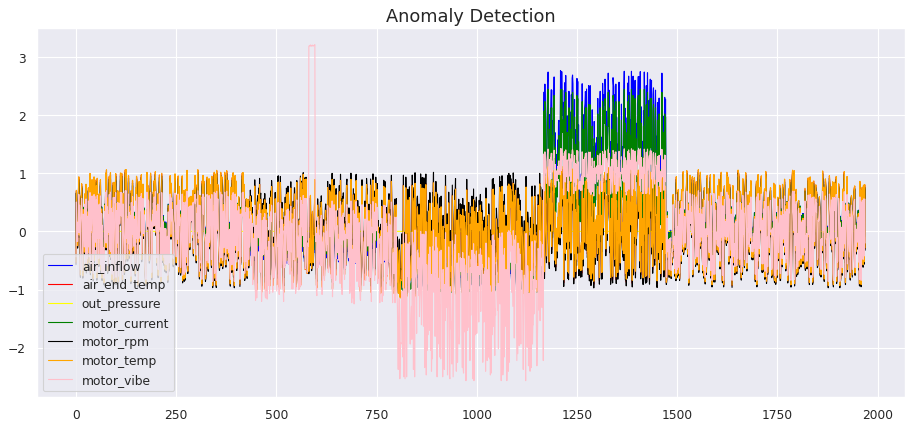

In [156]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(X_train['air_inflow'], label='air_inflow', color='blue', animated=True, linewidth=1)
ax.plot(X_train['air_end_temp'], label='air_end_temp', color='red', animated=True, linewidth=1)
ax.plot(X_train['out_pressure'], label='out_pressure', color='yellow', animated=True, linewidth=1)
ax.plot(X_train['motor_current'], label='motor_current', color='green', animated=True, linewidth=1)
ax.plot(X_train['motor_rpm'], label='motor_rpm', color='black', animated=True, linewidth=1)
ax.plot(X_train['motor_temp'], label='motor_temp', color='orange', animated=True, linewidth=1)
ax.plot(X_train['motor_vibe'], label='motor_vibe', color='pink', animated=True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Anomaly Detection', fontsize=16)
plt.show()

In [157]:
train_fft=np.fft.fft(X_train)
test_fft=np.fft.fft(X_test)

# **reshape inputs for LSTM**

In [158]:
Xtrain=X_train.to_numpy()
Xtest=X_test.to_numpy()
train_reshape = Xtrain.reshape(Xtrain.shape[0], 1, Xtrain.shape[1])
print("Training data shape: ", train_reshape.shape)
test_reshape = Xtest.reshape(Xtest.shape[0], 1, Xtest.shape[1])
print("Test data shape: ", test_reshape.shape)

Training data shape:  (1970, 1, 8)
Test data shape:  (493, 1, 8)


# **autoencoder network model**

In [159]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [160]:
model = autoencoder_model(train_reshape)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 lstm_16 (LSTM)              (None, 1, 16)             1600      
                                                                 
 lstm_17 (LSTM)              (None, 4)                 336       
                                                                 
 repeat_vector_4 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_18 (LSTM)              (None, 1, 4)              144       
                                                                 
 lstm_19 (LSTM)              (None, 1, 16)             1344      
                                                           

In [161]:
history = model.fit(train_reshape, train_reshape,
                        #shuffle=True,
                        epochs=100,
                        batch_size=10, validation_split=0.05).history

Epoch 1/100
188/188 [==============================] - 9s 11ms/step - loss: 0.6495 - val_loss: 0.8174
Epoch 2/100
188/188 [==============================] - 2s 10ms/step - loss: 0.4320 - val_loss: 0.6303
Epoch 3/100
188/188 [==============================] - 2s 11ms/step - loss: 0.3378 - val_loss: 0.4747
Epoch 4/100
188/188 [==============================] - 2s 11ms/step - loss: 0.2653 - val_loss: 0.3073
Epoch 5/100
188/188 [==============================] - 3s 17ms/step - loss: 0.2231 - val_loss: 0.2496
Epoch 6/100
188/188 [==============================] - 3s 13ms/step - loss: 0.2010 - val_loss: 0.1765
Epoch 7/100
188/188 [==============================] - 2s 12ms/step - loss: 0.1850 - val_loss: 0.1285
Epoch 8/100
188/188 [==============================] - 2s 11ms/step - loss: 0.1750 - val_loss: 0.0977
Epoch 9/100
188/188 [==============================] - 2s 11ms/step - loss: 0.1665 - val_loss: 0.1035
Epoch 10/100
188/188 [==============================] - 2s 10ms/step - loss: 0.158

# **training losses**

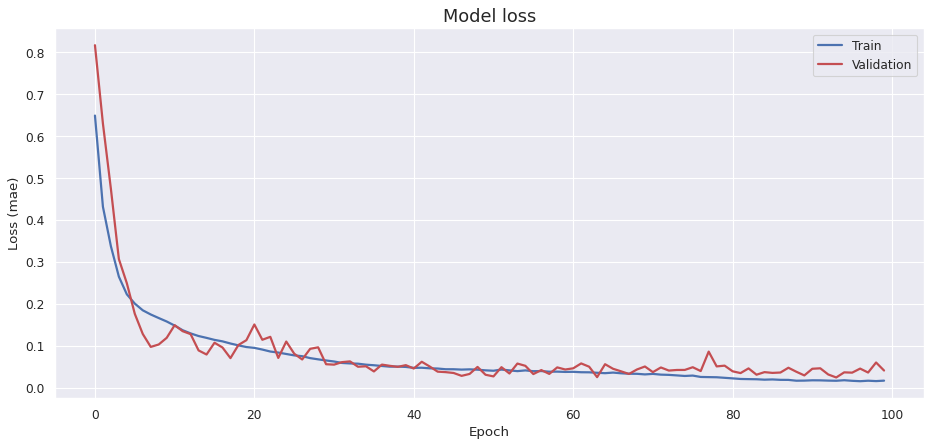

In [162]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [163]:
train_reshape

array([[[-0.24025974, -0.54083362,  0.        , ..., -0.53104762,
         -0.43758984,  0.        ]],

       [[ 0.65584416,  0.69806845,  0.        , ...,  0.70628571,
          0.50514318,  0.        ]],

       [[-0.03246753, -0.25008472,  0.        , ..., -0.2407619 ,
         -0.17411016,  0.        ]],

       ...,

       [[-0.23376623, -0.53202304,  0.        , ..., -0.52266667,
         -0.42285584,  5.        ]],

       [[ 0.72727273,  0.79837343,  0.        , ...,  0.80685714,
          0.55789695,  5.        ]],

       [[-0.06493506, -0.29142664,  0.        , ..., -0.28266667,
         -0.20029346,  5.        ]]])

In [164]:
train_reshape.shape[0]

1970

In [165]:
train_reshape.shape[2]

8

62/62 [==============================] - 1s 2ms/step


<ipython-input-166-fd8985f57722>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');


(0.0, 0.5)

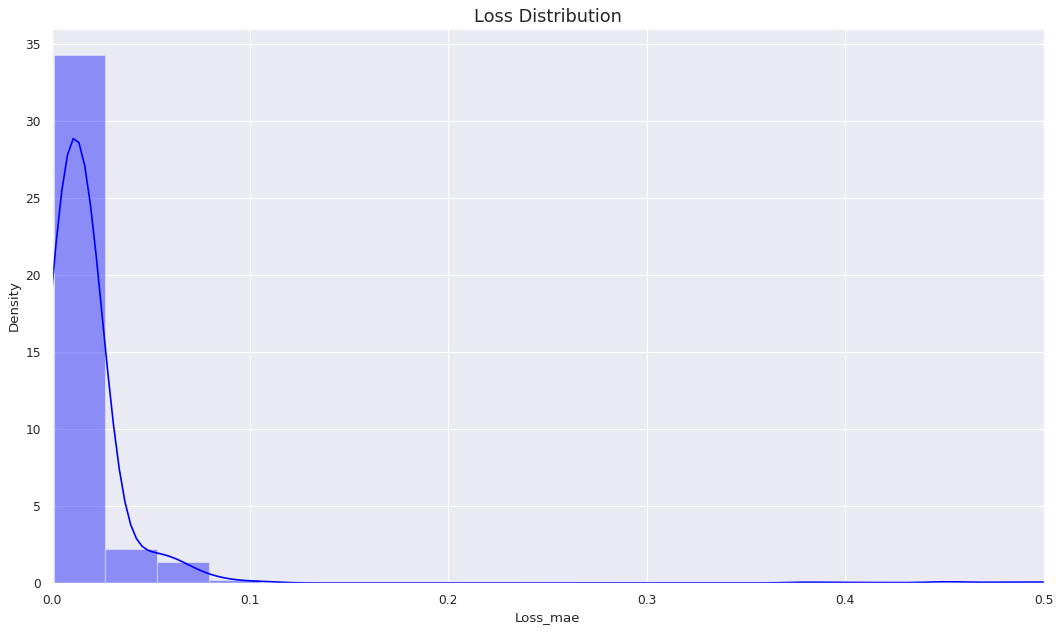

In [166]:
X_pred = model.predict(train_reshape)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
#train = pd.DataFrame(train, columns = ['air_inflow', 'air_end_temp', 'out_pressure', 'motor_current', 'motor_rpm', 'motor_temp', 'motor_vibe', 'type'])
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
Xtrain = train_reshape.reshape(train_reshape.shape[0], train_reshape.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins = 20, kde= True, color = 'blue');
plt.xlim([0.0,.5])

In [167]:
pred = model.predict(test_reshape)
pred = pred.reshape(pred.shape[0], pred.shape[2])
pred = pd.DataFrame(pred, columns=X_test.columns)
pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
Xtest = test_reshape.reshape(test_reshape.shape[0], test_reshape.shape[2])
scored['Loss_mae'] = np.mean(np.abs(pred-Xtest), axis = 1)
scored['Threshold'] = 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

16/16 [==============================] - 0s 3ms/step


,Loss_mae,Threshold,Anomaly
1970,0.089449,0.275,False
1971,0.029618,0.275,False
1972,0.061270,0.275,False
1973,0.039256,0.275,False
1974,0.021857,0.275,False


In [168]:
X_pred_train = model.predict(train_reshape)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

62/62 [==============================] - 0s 3ms/step


In [169]:
train_reshape

array([[[-0.24025974, -0.54083362,  0.        , ..., -0.53104762,
         -0.43758984,  0.        ]],

       [[ 0.65584416,  0.69806845,  0.        , ...,  0.70628571,
          0.50514318,  0.        ]],

       [[-0.03246753, -0.25008472,  0.        , ..., -0.2407619 ,
         -0.17411016,  0.        ]],

       ...,

       [[-0.23376623, -0.53202304,  0.        , ..., -0.52266667,
         -0.42285584,  5.        ]],

       [[ 0.72727273,  0.79837343,  0.        , ...,  0.80685714,
          0.55789695,  5.        ]],

       [[-0.06493506, -0.29142664,  0.        , ..., -0.28266667,
         -0.20029346,  5.        ]]])

<Axes: >

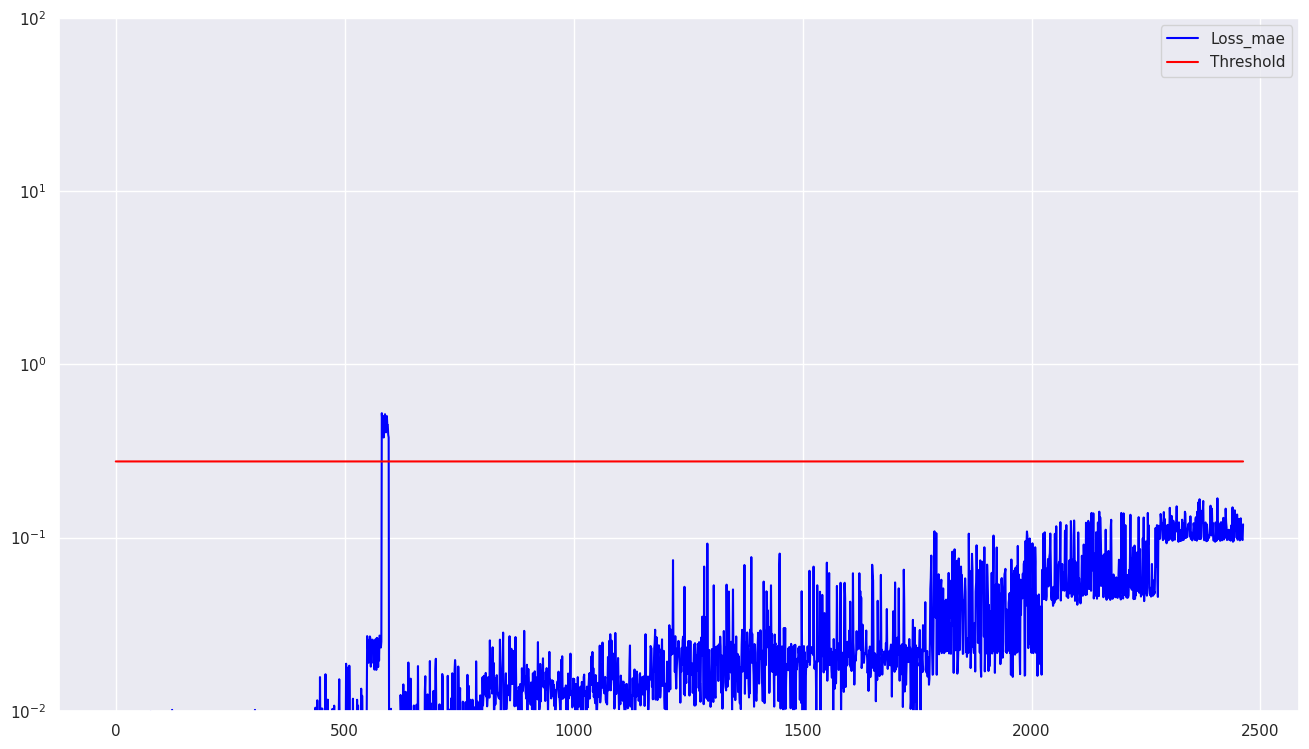

In [170]:
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

In [171]:
pred

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
1970,0.706123,0.876631,-0.002828,0.788474,0.794795,0.883532,0.458656,5.066322
1971,0.024273,-0.156579,0.003048,0.000674,-0.220443,-0.159984,-0.149714,5.015128
1972,0.570543,0.678978,-0.001928,0.632162,0.601641,0.682993,0.346379,5.024753
1973,0.185032,0.066438,0.000294,0.178624,-0.010819,0.064546,-0.005683,5.014010
1974,-0.232854,-0.496331,-0.000552,-0.252086,-0.576059,-0.508303,-0.468866,5.039773
...,...,...,...,...,...,...,...,...
2458,0.042520,0.175590,0.022078,0.086149,0.044522,0.148361,-0.154509,6.850901
2459,-0.070079,0.009162,0.020498,-0.032074,-0.134591,-0.026816,-0.292751,6.886403
2460,-0.500537,-0.625952,0.021418,-0.477708,-0.775126,-0.687097,-0.824729,6.960240
2461,-0.491442,-0.611784,0.021318,-0.468177,-0.761382,-0.672544,-0.813266,6.960151


In [172]:
test

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,0.382550,0.299934,0.0,0.341372,0.256260,0.304576,0.255637,0
1,0.483221,0.429993,0.0,0.443730,0.387312,0.435109,0.355373,0
2,-0.147651,-0.399469,0.0,-0.211147,-0.447412,-0.398350,-0.313396,0
3,0.174497,0.025879,0.0,0.124866,-0.019199,0.029257,0.047798,0
4,0.080537,-0.098208,0.0,0.026795,-0.144407,-0.096024,-0.060619,0
...,...,...,...,...,...,...,...,...
7384,0.120805,-0.045123,0.0,0.068596,-0.090985,-0.042011,-0.012046,7
7385,-0.308725,-0.605839,0.0,-0.374062,-0.655259,-0.606152,-0.501036,7
7386,-0.255034,-0.540810,0.0,-0.322615,-0.589316,-0.540135,-0.432943,7
7387,-0.234899,-0.515594,0.0,-0.302787,-0.564274,-0.514629,-0.419471,7


In [173]:
y_test=test.to_numpy()
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

In [174]:
test

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,0.382550,0.299934,0.0,0.341372,0.256260,0.304576,0.255637,0
1,0.483221,0.429993,0.0,0.443730,0.387312,0.435109,0.355373,0
2,-0.147651,-0.399469,0.0,-0.211147,-0.447412,-0.398350,-0.313396,0
3,0.174497,0.025879,0.0,0.124866,-0.019199,0.029257,0.047798,0
4,0.080537,-0.098208,0.0,0.026795,-0.144407,-0.096024,-0.060619,0
...,...,...,...,...,...,...,...,...
7384,0.120805,-0.045123,0.0,0.068596,-0.090985,-0.042011,-0.012046,7
7385,-0.308725,-0.605839,0.0,-0.374062,-0.655259,-0.606152,-0.501036,7
7386,-0.255034,-0.540810,0.0,-0.322615,-0.589316,-0.540135,-0.432943,7
7387,-0.234899,-0.515594,0.0,-0.302787,-0.564274,-0.514629,-0.419471,7


In [175]:
pred = model.predict(y_test)

231/231 [==============================] - 1s 3ms/step


In [176]:
pred = pred.reshape(pred.shape[0], pred.shape[2])
pred = pd.DataFrame(pred, columns=test.columns)
pred.index = test.index

scored = pd.DataFrame(index=test.index)
Ytest = y_test.reshape(y_test.shape[0], y_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(pred-Ytest), axis = 1)
scored['Threshold'] = 0.275
anomaly = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold
0,0.008048,0.275
1,0.012960,0.275
2,0.009260,0.275
3,0.005827,0.275
4,0.007834,0.275


In [177]:
anomaly

0       False
1       False
2       False
3       False
4       False
        ...  
7384    False
7385    False
7386    False
7387    False
7388    False
Length: 7389, dtype: bool

In [178]:
label = pd.DataFrame(anomaly, columns=['label'])

In [179]:
submit = pd.read_csv('/content/drive/MyDrive/AISpark/dataset/answer_sample.csv')
submit = submit.drop(['type','label'],axis=1)
submit = pd.concat([pd.DataFrame(test['type']),label['label']],axis=1)

In [180]:
submit

,type,label
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False
...,...,...
7384,7,False
7385,7,False
7386,7,False
7387,7,False


In [182]:
submit.to_csv('0410.csv',index = False)